# Лабораторная работа №1
Пан Анатолий Эдуардович<br>
Группа 932209<br>
Нечетный вариант

## Подключаем kaggle для импорта наборов данных

In [ ]:
# Install kaggle
!pip install -q kaggle

In [ ]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Change directory
import os
os.chdir("/content/drive/MyDrive/Nauchka")

In [ ]:
# Create a kaggle folder
!mkdir -p ~/.kaggle

# Copy kaggle.json to created folder
!cp kaggle.json ~/.kaggle/

In [ ]:
os.chdir("/content")

In [ ]:
# Permission for the json to act
!chmod 600 ~/.kaggle/kaggle.json

## Импорт всех необходимых библиотек

In [ ]:
from zipfile import ZipFile
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score, recall_score, precision_score, balanced_accuracy_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, roc_curve, auc
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.optimizers import Adam
from keras.metrics import Recall, Precision, AUC, Accuracy
from keras.utils import plot_model, to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping

## Бинарная классификация

Скачиваем необходимый набор данных

In [ ]:
!kaggle datasets download -d alexteboul/diabetes-health-indicators-dataset

 99% 6.00M/6.03M [00:00<00:00, 57.9MB/s]
100% 6.03M/6.03M [00:00<00:00, 57.6MB/s]


Распаковка датасета

In [ ]:
# Unzip our dataset
file_to_extract = "diabetes-health-indicators-dataset.zip"

# Open your .zip file
with ZipFile(file=file_to_extract) as zip_file:

    # Loop over each file and extract them
    for file in tqdm(iterable=zip_file.namelist(), total=len(zip_file.namelist())):
        zip_file.extract(member=file)

100%|██████████| 3/3 [00:00<00:00,  6.75it/s]


### Предобработка данных

In [ ]:
df = pd.read_csv("diabetes_012_health_indicators_BRFSS2015.csv")
df.head()

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


Информация о столбцах набора данных

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_012          253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

Статистические показатели набора данных

In [ ]:
df.describe()

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
count,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,...,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000
mean,0.296921,0.429001,0.424121,0.962670,28.382364,0.443169,0.040571,0.094186,0.756544,0.634256,...,0.951053,0.084177,2.511392,3.184772,4.242081,0.168224,0.440342,8.032119,5.050434,6.053875
std,0.698160,0.494934,0.494210,0.189571,6.608694,0.496761,0.197294,0.292087,0.429169,0.481639,...,0.215759,0.277654,1.068477,7.412847,8.717951,0.374066,0.496429,3.054220,0.985774,2.071148
min,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,1.000000,24.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,6.000000,4.000000,5.000000
50%,0.000000,0.000000,0.000000,1.000000,27.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,8.000000,5.000000,7.000000
75%,0.000000,1.000000,1.000000,1.000000,31.000000,1.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,3.000000,2.000000,3.000000,0.000000,1.000000,10.000000,6.000000,8.000000
max,2.000000,1.000000,1.000000,1.000000,98.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,5.000000,30.000000,30.000000,1.000000,1.000000,13.000000,6.000000,8.000000


Проверка данных на пустые значения

In [ ]:
df.isnull().mean()

Diabetes_012            0.0
HighBP                  0.0
HighChol                0.0
CholCheck               0.0
BMI                     0.0
Smoker                  0.0
Stroke                  0.0
HeartDiseaseorAttack    0.0
PhysActivity            0.0
Fruits                  0.0
Veggies                 0.0
HvyAlcoholConsump       0.0
AnyHealthcare           0.0
NoDocbcCost             0.0
GenHlth                 0.0
MentHlth                0.0
PhysHlth                0.0
DiffWalk                0.0
Sex                     0.0
Age                     0.0
Education               0.0
Income                  0.0
dtype: float64

Проверка на дубликаты и их удаление

In [ ]:
df.duplicated().sum()

23899

In [ ]:
# Drop duplicates
df.drop_duplicates(inplace=True)
df.shape

(229781, 22)

Рассмотрим целевую (target) переменную

In [ ]:
df["Diabetes_012"].value_counts()

0.0    190055
2.0     35097
1.0      4629
Name: Diabetes_012, dtype: int64

Объединим классы 1 и 2 как единый "положительный"

In [ ]:
df[df["Diabetes_012"]==2] = 1.0

In [ ]:
df["Diabetes_012"].value_counts()

0.0    190055
1.0     39726
Name: Diabetes_012, dtype: int64

Переименуем столбец целевой переменной

In [ ]:
df["Diabetes"] = df["Diabetes_012"]
df.drop(columns = "Diabetes_012", inplace=True)

Посмотрим на распределение целевого признака

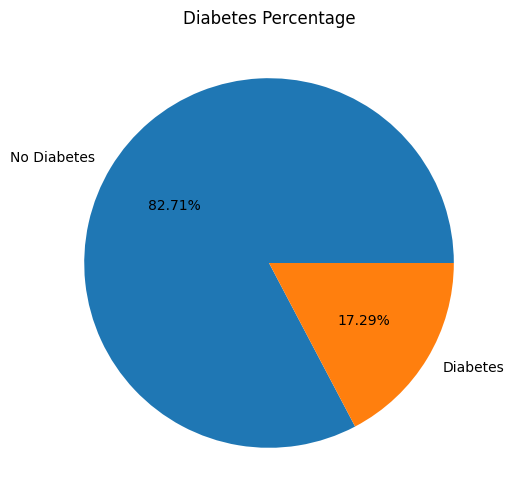

In [ ]:
plt.figure(figsize=(10,6))
plt.pie(df['Diabetes'].value_counts(), labels=['No Diabetes', 'Diabetes'], autopct='%1.2f%%')
plt.title('Diabetes Percentage')
plt.show()

In [ ]:
df = df.astype('int32')

Т.к. данные несбалансированны, то проведем undersampling

Undersampling

In [ ]:
majority_class = df[df['Diabetes'] == 0]
minority_class = df[df['Diabetes'] == 1]

In [ ]:
majority_class_downsampled = resample(majority_class,
                                      replace=False,
                                      n_samples=len(minority_class),
                                      random_state=42)

In [ ]:
df_resampled = pd.concat([majority_class_downsampled, minority_class])

In [ ]:
df = df_resampled

### Создание нейросетевой модели

In [ ]:
# Target dataframe
X = df.drop('Diabetes', axis=1)
y = df['Diabetes']

In [ ]:
min_max_scaler = MinMaxScaler()
X = min_max_scaler.fit_transform(X)

Разделим набор данных на 3 выборки

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [ ]:
X_train.shape

(63561, 21)

Создадим модель и начнем ее обучение

In [ ]:
model = keras.Sequential([
    layers.Dense(8, activation="relu", input_dim=X_train.shape[1]),
    layers.Dense(4, activation="relu"),
    layers.Dense(1, activation="sigmoid"),
])

In [ ]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_81 (Dense)            (None, 8)                 80        
                                                                 
 dense_82 (Dense)            (None, 4)                 36        
                                                                 
 dense_83 (Dense)            (None, 1)                 5         
                                                                 
Total params: 121 (484.00 Byte)
Trainable params: 121 (484.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.compile(optimizer=Adam(0.00001),
              loss="binary_crossentropy",
              metrics=[Recall(),
                       Precision(),
                       "AUC",
                       "accuracy"])

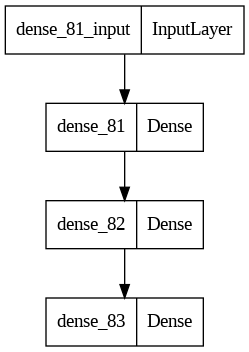

In [ ]:
plot_model(model, to_file='binary_model.png')

Для если не будет никаких изменений валидационной точности в течении 10 эпох, то остановим обучение

In [ ]:
early_stop = EarlyStopping(monitor='val_accuracy',
                           patience=10,
                           mode='max',
                           verbose=1
                           )
checkpoint = ModelCheckpoint('diabet_weights-{epoch:02d}-{val_accuracy:.3f}.hdf5',
                             monitor='val_accuracy',
                             verbose=1,
                             mode='max',
                             save_best_only=True
                             )

callbacks_list=[early_stop, checkpoint]

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50,
                    batch_size=64,
                    callbacks=callbacks_list)

Epoch 1/50
966/994 [============================>.] - ETA: 0s - loss: 0.6203 - recall_1: 0.9116 - precision_1: 0.8095 - auc: 0.9468 - accuracy: 0.8485
Epoch 1: val_accuracy improved from -inf to 0.85450, saving model to diabet_weights-01-0.854.hdf5
994/994 [==============================] - 4s 3ms/step - loss: 0.6199 - recall_1: 0.9119 - precision_1: 0.8100 - auc: 0.9471 - accuracy: 0.8490 - val_loss: 0.6073 - val_recall_1: 0.9119 - val_precision_1: 0.8180 - val_auc: 0.9469 - val_accuracy: 0.8545
Epoch 2/50
 88/994 [=>............................] - ETA: 1s - loss: 0.6043 - recall_1: 0.9156 - precision_1: 0.8185 - auc: 0.9530 - accuracy: 0.8580

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


994/994 [==============================] - ETA: 0s - loss: 0.5940 - recall_1: 0.9084 - precision_1: 0.8363 - auc: 0.9489 - accuracy: 0.8653
Epoch 2: val_accuracy improved from 0.85450 to 0.87338, saving model to diabet_weights-02-0.873.hdf5
994/994 [==============================] - 2s 2ms/step - loss: 0.5940 - recall_1: 0.9084 - precision_1: 0.8363 - auc: 0.9489 - accuracy: 0.8653 - val_loss: 0.5813 - val_recall_1: 0.9089 - val_precision_1: 0.8486 - val_auc: 0.9475 - val_accuracy: 0.8734
Epoch 3/50
973/994 [============================>.] - ETA: 0s - loss: 0.5675 - recall_1: 0.9053 - precision_1: 0.8581 - auc: 0.9494 - accuracy: 0.8776
Epoch 3: val_accuracy improved from 0.87338 to 0.88232, saving model to diabet_weights-03-0.882.hdf5
994/994 [==============================] - 2s 2ms/step - loss: 0.5671 - recall_1: 0.9057 - precision_1: 0.8581 - auc: 0.9497 - accuracy: 0.8779 - val_loss: 0.5536 - val_recall_1: 0.9061 - val_precision_1: 0.8649 - val_auc: 0.9481 - val_accuracy: 0.8823
E

Построим графики зависимости потерь и точности от количества эпох

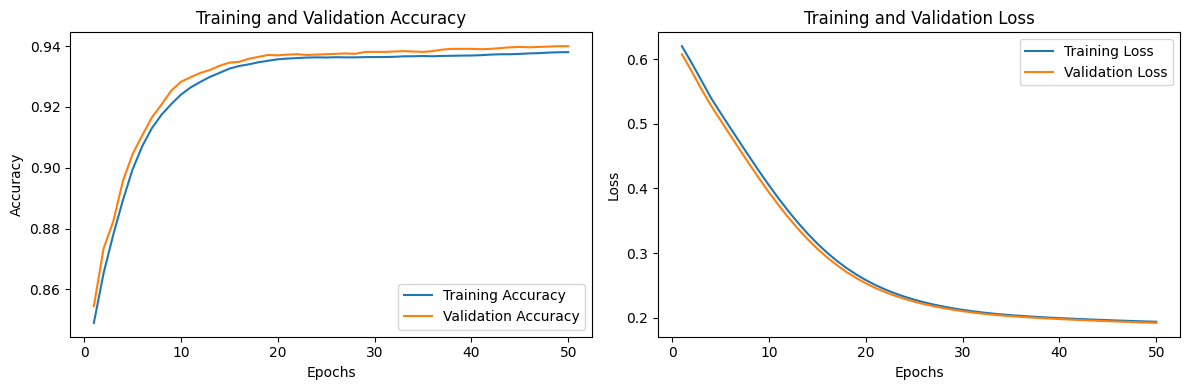

In [ ]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Выполним предсказание и выведем все необходимые метрики

In [ ]:
model.load_weights("diabet_weights-49-0.940.hdf5")

In [ ]:
results = model.evaluate(X_test, y_test)

249/249 [==============================] - 1s 4ms/step - loss: 0.1860 - recall_1: 0.8940 - precision_1: 0.9902 - auc: 0.9553 - accuracy: 0.9426


In [ ]:
y_pred = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

249/249 [==============================] - 2s 8ms/step


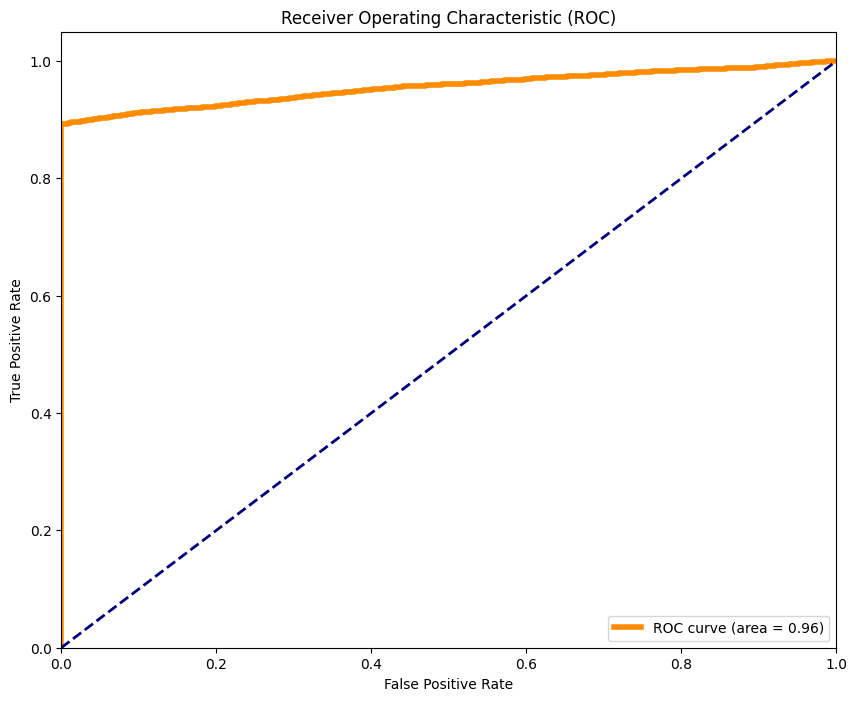

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=4, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for Binary Classification')
plt.legend(loc='lower right')
plt.show()

## Многоклассовый классификатор

Скачиваем необходимый набор данных

In [ ]:
!kaggle datasets download -d kukuroo3/body-performance-data

  0% 0.00/249k [00:00<?, ?B/s]
100% 249k/249k [00:00<00:00, 94.8MB/s]


Разархивируем его

In [ ]:
# Unzip our dataset
file_to_extract = "/content/body-performance-data.zip"

# Open your .zip file
with ZipFile(file=file_to_extract) as zip_file:

    # Loop over each file and extract them
    for file in tqdm(iterable=zip_file.namelist(), total=len(zip_file.namelist())):
        zip_file.extract(member=file)

100%|██████████| 1/1 [00:00<00:00, 165.03it/s]


### Предобработка данных

In [ ]:
df = pd.read_csv("/content/bodyPerformance.csv")
df.head()

,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class
0,27.0,M,172.3,75.24,21.3,80.0,130.0,54.9,18.4,60.0,217.0,C
1,25.0,M,165.0,55.80,15.7,77.0,126.0,36.4,16.3,53.0,229.0,A
2,31.0,M,179.6,78.00,20.1,92.0,152.0,44.8,12.0,49.0,181.0,C
3,32.0,M,174.5,71.10,18.4,76.0,147.0,41.4,15.2,53.0,219.0,B
4,28.0,M,173.8,67.70,17.1,70.0,127.0,43.5,27.1,45.0,217.0,B


Информация о наборе данных

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13393 entries, 0 to 13392
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      13393 non-null  float64
 1   gender                   13393 non-null  object 
 2   height_cm                13393 non-null  float64
 3   weight_kg                13393 non-null  float64
 4   body fat_%               13393 non-null  float64
 5   diastolic                13393 non-null  float64
 6   systolic                 13393 non-null  float64
 7   gripForce                13393 non-null  float64
 8   sit and bend forward_cm  13393 non-null  float64
 9   sit-ups counts           13393 non-null  float64
 10  broad jump_cm            13393 non-null  float64
 11  class                    13393 non-null  object 
dtypes: float64(10), object(2)
memory usage: 1.2+ MB


Статистические данные датасета

In [ ]:
df.describe()

,age,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm
count,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000
mean,36.775106,168.559807,67.447316,23.240165,78.796842,130.234817,36.963877,15.209268,39.771224,190.129627
std,13.625639,8.426583,11.949666,7.256844,10.742033,14.713954,10.624864,8.456677,14.276698,39.868000
min,21.000000,125.000000,26.300000,3.000000,0.000000,0.000000,0.000000,-25.000000,0.000000,0.000000
25%,25.000000,162.400000,58.200000,18.000000,71.000000,120.000000,27.500000,10.900000,30.000000,162.000000
50%,32.000000,169.200000,67.400000,22.800000,79.000000,130.000000,37.900000,16.200000,41.000000,193.000000
75%,48.000000,174.800000,75.300000,28.000000,86.000000,141.000000,45.200000,20.700000,50.000000,221.000000
max,64.000000,193.800000,138.100000,78.400000,156.200000,201.000000,70.500000,213.000000,80.000000,303.000000


Проверка на дубликаты и их последующее удаление

In [ ]:
df.duplicated().sum()

1

In [ ]:
df.drop_duplicates(inplace=True)
df.shape

(13392, 12)

Посмотрим на распределение роста и веса пациентов

<Axes: xlabel='height_cm', ylabel='weight_kg'>

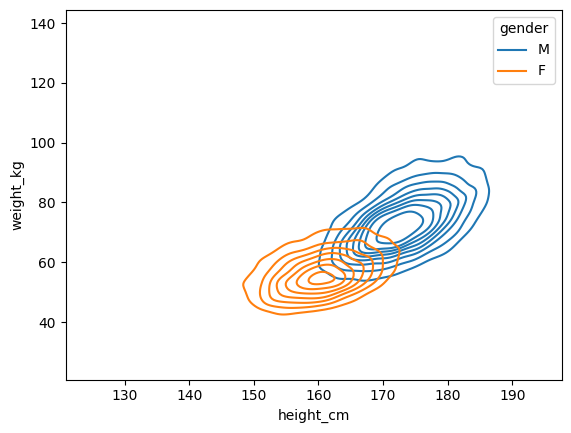

In [ ]:
sns.kdeplot(data=df, x='height_cm', y='weight_kg', hue='gender', fill=False, thresh=False, cbar=False)

Распределение целевой переменной

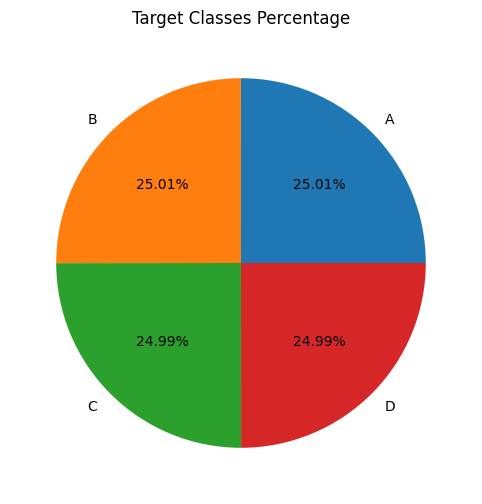

In [ ]:
plt.figure(figsize=(10,6))
plt.pie(df["class"].value_counts(), labels=["A", "B", "C", "D"], autopct="%1.2f%%")
plt.title('Target Classes Percentage')
plt.show()

Корреляция между признаками

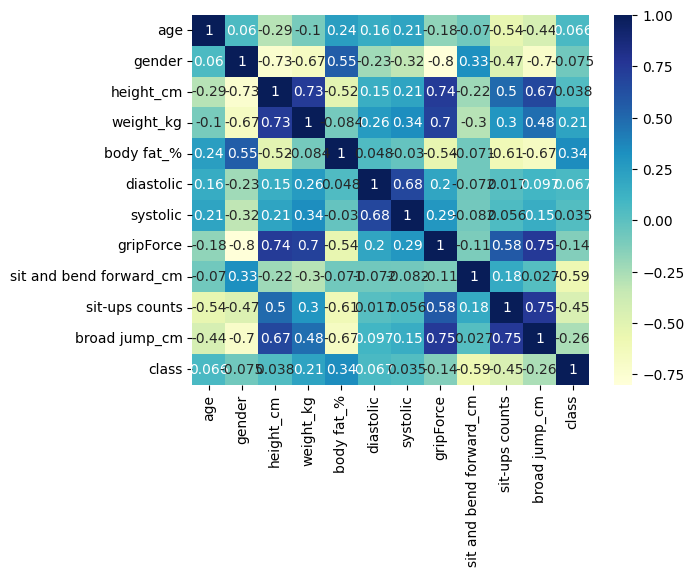

In [ ]:
dataplot = sns.heatmap(df.corr(), cmap="YlGnBu", annot=True)
plt.show()

Категориальные переменные

In [ ]:
df["class"].replace(['A', 'B', 'C', 'D'], [0, 1, 2, 3], inplace=True)
df["gender"].replace(['M', 'F'], [0, 1], inplace=True)
df.head()

,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class
0,27.0,0,172.3,75.24,21.3,80.0,130.0,54.9,18.4,60.0,217.0,2
1,25.0,0,165.0,55.80,15.7,77.0,126.0,36.4,16.3,53.0,229.0,0
2,31.0,0,179.6,78.00,20.1,92.0,152.0,44.8,12.0,49.0,181.0,2
3,32.0,0,174.5,71.10,18.4,76.0,147.0,41.4,15.2,53.0,219.0,1
4,28.0,0,173.8,67.70,17.1,70.0,127.0,43.5,27.1,45.0,217.0,1


Разделим данные на датафрейм признаков и на целевой

In [ ]:
X = df.drop(["height_cm", "systolic", "class"], axis=1)
y = df["class"]

Произведем кодирование таргета

In [ ]:
encoder = LabelEncoder()
y = encoder.fit_transform(df["class"])
y = to_categorical(y, num_classes=4)

Отмасштабируем признаки

In [ ]:
min_max_scaler = MinMaxScaler()
X = min_max_scaler.fit_transform(X)

Разделим набор данных на 3 выборки

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [ ]:
X_train.shape

(10713, 9)

### Создание нейросетевой модели

Полученная нейросетевая модель

In [ ]:
# current model
model = keras.Sequential([
    layers.Dense(128, activation="relu", input_dim=X_train.shape[1]),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.2),

    layers.Dense(64, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(8, activation="relu"),

    layers.Dense(4, activation="softmax"),
])

In [ ]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_74 (Dense)            (None, 128)               1280      
                                                                 
 dense_75 (Dense)            (None, 256)               33024     
                                                                 
 dropout_8 (Dropout)         (None, 256)               0         
                                                                 
 dense_76 (Dense)            (None, 64)                16448     
                                                                 
 dense_77 (Dense)            (None, 32)                2080      
                                                                 
 dense_78 (Dense)            (None, 16)                528       
                                                                 
 dense_79 (Dense)            (None, 8)               

Начнем обучение

In [ ]:
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=[Recall(),
                       Precision(),
                       "AUC",
                       "accuracy"])

Для если не будет никаких изменений валидационной точности в течении 10 эпох, то остановим обучение

In [ ]:
early_stop = EarlyStopping(monitor='val_accuracy',
                           patience=10,
                           mode='max',
                           verbose=1
                           )
checkpoint = ModelCheckpoint('multi_class-{epoch:02d}-{val_accuracy:.3f}.hdf5',
                             monitor='val_accuracy',
                             verbose=1,
                             mode='max',
                             save_best_only=True
                             )

callbacks_list=[early_stop, checkpoint]

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200,
                    batch_size=64,
                    callbacks=callbacks_list)

Epoch 1/200
167/168 [============================>.] - ETA: 0s - loss: 1.2827 - recall_5: 0.0753 - precision_5: 0.8082 - auc: 0.6544 - accuracy: 0.3501
Epoch 1: val_accuracy improved from -inf to 0.46453, saving model to multi_class-01-0.465.hdf5
168/168 [==============================] - 3s 6ms/step - loss: 1.2826 - recall_5: 0.0754 - precision_5: 0.8088 - auc: 0.6547 - accuracy: 0.3502 - val_loss: 1.1576 - val_recall_5: 0.1382 - val_precision_5: 0.9635 - val_auc: 0.7819 - val_accuracy: 0.4645
Epoch 2/200
167/168 [============================>.] - ETA: 0s - loss: 1.1080 - recall_5: 0.1679 - precision_5: 0.8013 - auc: 0.7864 - accuracy: 0.5418
Epoch 2: val_accuracy improved from 0.46453 to 0.55713, saving model to multi_class-02-0.557.hdf5
168/168 [==============================] - 1s 4ms/step - loss: 1.1081 - recall_5: 0.1677 - precision_5: 0.8004 - auc: 0.7865 - accuracy: 0.5419 - val_loss: 1.0421 - val_recall_5: 0.1837 - val_precision_5: 0.8066 - val_auc: 0.8218 - val_accuracy: 0.55

Построим графики зависимости потерь и точности от количества эпох

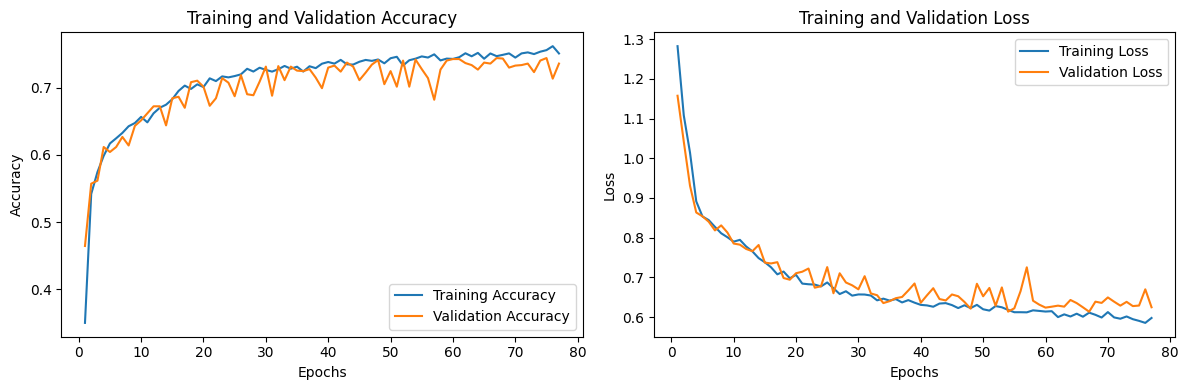

In [ ]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

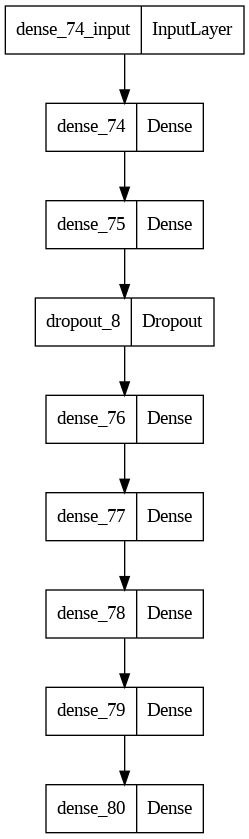

In [ ]:
plot_model(model, to_file='multi_model.png')

Сделаем предсказание и посчитаем необходимые нам метрики качества

In [ ]:
model.load_weights("multi_class-67-0.744.hdf5")

In [ ]:
results = model.evaluate(X_test, y_test)

42/42 [==============================] - 0s 4ms/step - loss: 0.6240 - recall_5: 0.6769 - precision_5: 0.7921 - auc: 0.9315 - accuracy: 0.7507


In [ ]:
y_pred = model.predict(X_test)

42/42 [==============================] - 0s 997us/step


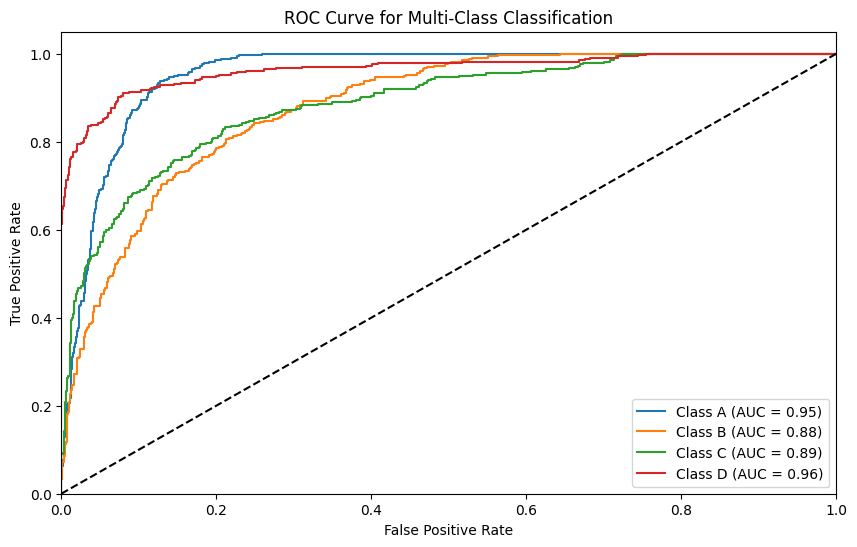

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 6))

for i in range(4):
    plt.plot(fpr[i], tpr[i], label=f'Class {chr(65 + i)} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend(loc='best')
plt.show()

Видимо, что пациент 44 принадлежит к классу D с вероятностью 0.9995

In [ ]:
x_test_pattern = X_test[44,:]
original_features= min_max_scaler.inverse_transform(x_test_pattern.reshape(1,-1))
print(original_features)

y_pred = model.predict(x_test_pattern.reshape(1,-1))
print(y_pred[0])

[[ 32.    1.  154.   53.2  24.5  67.   29.1  20.7  15. ]]
1/1 [==============================] - 0s 74ms/step
[3.2191922e-22 3.4569181e-11 4.8251270e-04 9.9951744e-01]


## Регрессор

Чтение набора данных


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/masters/DL/labs/DS_2019_public.csv", encoding="latin-1")
df.head()

<ipython-input-86-b44520a885eb>:1: DtypeWarning: Columns (30,56,96,114) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/drive/MyDrive/masters/DL/labs/DS_2019_public.csv", encoding="latin-1")


,Climate_Region_Pub,DIVISION,REPORTABLE_DOMAIN,DOLELCOL,TOTALDOLCOL,KWHCOL,BTUELCOL,TOTALBTUCOL,TOTALDOLSPH,TOTALBTUSPH,...,LGT1EE,TOTALBTUWTH,ROOFTYPE,DOLELRFG,TOTALDOLRFG,HEATROOM,WDWATER,UGWARM,DRYRFUEL,KWHRFG
0,5,10,26,16.793,17,181.998,620.979,621,368,38606,...,-2,30110,2,120.893,121,4,0,1,1,1310.220
1,1,1,1,48.901,49,184.459,629.389,629,582,40248,...,2,7933,-2,242.746,243,2,0,1,-2,915.664
2,1,3,7,101.048,101,1063.022,3627.013,3627,425,40196,...,-2,6440,5,158.797,159,7,0,1,5,1670.534
3,1,1,1,0,0,0.000,0.000,0,616,36136,...,2,13884,5,85.138,85,5,0,1,5,346.468
4,1,4,10,45.132,45,274.530,936.677,937,685,74100,...,3,14204,6,151.319,151,6,0,1,5,920.454


In [ ]:
df.shape

(10875, 121)

Будем предсказывать `TOTALDOLWTH` (Total cost for water heating, in whole dollars)

### Предобработка данных

Информация о датасете

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10875 entries, 0 to 10874
Columns: 121 entries, Climate_Region_Pub to KWHRFG
dtypes: float64(34), int64(79), object(8)
memory usage: 10.0+ MB


В наборе данных есть некоторые ошибки в данных. Вместо чисел записаны даты. Удалим эти столбцы. Для начала определим в каких столбцах встречаются такие записи

In [ ]:
object_cols = list(df.dtypes[df.dtypes == 'object'].keys())
object_cols

['DOLELCOL',
 'DOLFOSPH',
 'DOLELSPH',
 'DOLNGWTH',
 'CUFEETNGOTH',
 'KWHOTH',
 'CUFEETNGWTH',
 'DOLELRFG']

In [ ]:
df = df.drop(object_cols, axis=1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10875 entries, 0 to 10874
Columns: 113 entries, Climate_Region_Pub to KWHRFG
dtypes: float64(34), int64(79)
memory usage: 9.4 MB


Выберем более 5 признаков для проведения предсказания нашего target. Для этого выберем не признаки, значения корреляции которых с target &ge; 0.4

In [ ]:
# Построим корреляционную матрицу признаков
correlation_matrix = df.corr()

# Выберите корреляцию между целевым признаком и остальными признаками
correlation_with_target = correlation_matrix['TOTALDOLWTH'].sort_values(ascending=False)

# correlation_with_target теперь содержит корреляции с целевым признаком, упорядоченные по убыванию
feature_cols = list(correlation_with_target[:12].keys())

Получилось 11 таких признаков

In [ ]:
correlation_with_target[:12]

TOTALDOLWTH    1.000000
TOTALBTUWTH    0.702407
TOTALDOL       0.615648
TOTALBTU       0.499288
DOLLAREL       0.497141
TOTALDOLOTH    0.459576
DOLELOTH       0.447901
KWH            0.435446
BTUEL          0.435446
BTUELOTH       0.415200
DOLELWTH       0.404145
TOTALBTUOTH    0.401453
Name: TOTALDOLWTH, dtype: float64

Оставим только эти 11 признаков + целевая переменная

In [ ]:
df = df[feature_cols]

Посмотрим на выбросы в данных

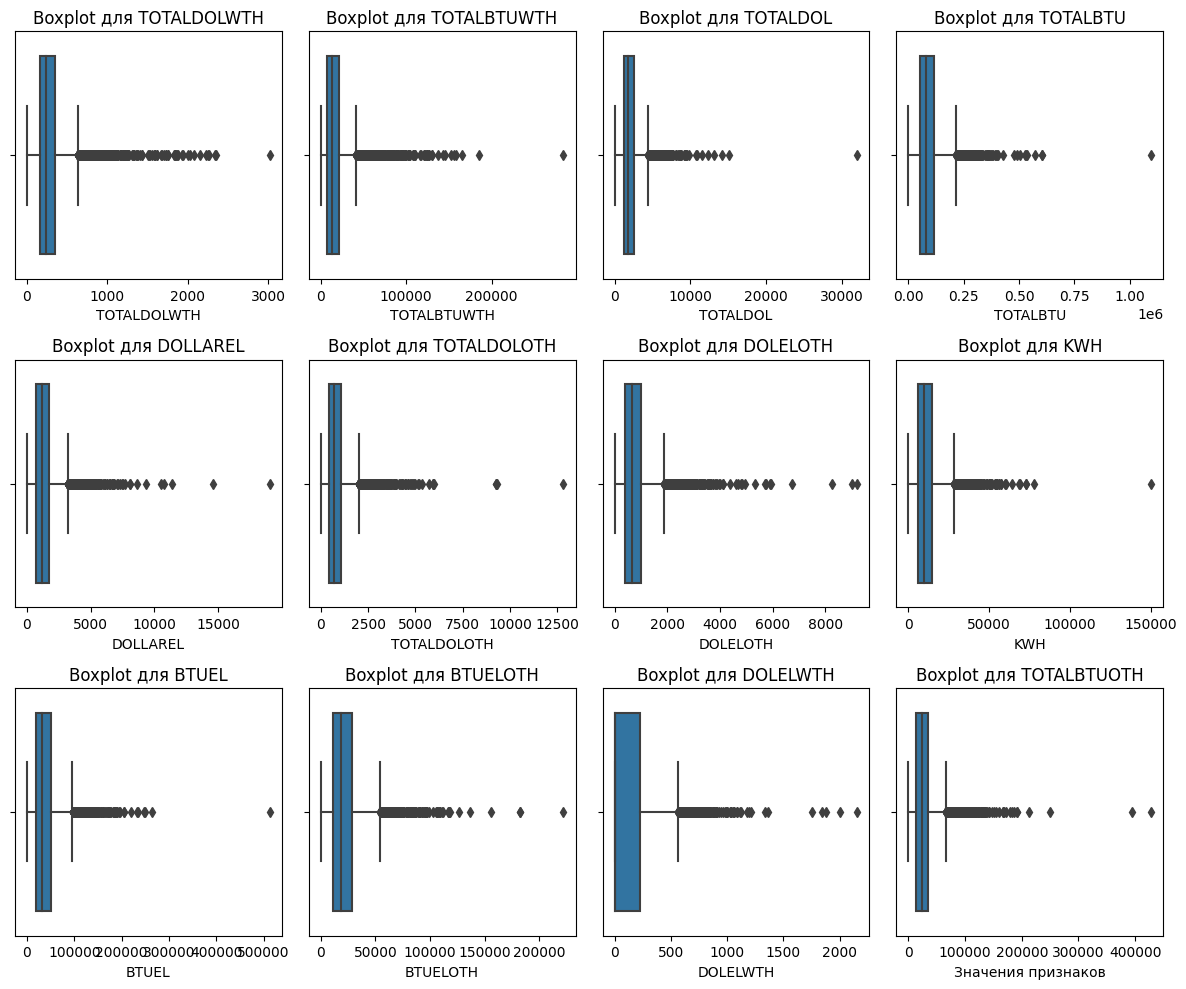

In [ ]:
# Создайте фигуру и массив подграфиков
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 10))  # Измените размер по вашему усмотрению

# Создайте отдельный boxplot для каждого признака
for i, column in enumerate(df.columns):
    row = i // 4
    col = i % 4
    sns.boxplot(x=df[column], ax=axes[row, col])
    axes[row, col].set_title(f'Boxplot для {column}')

# Настройте метки осей
plt.xlabel("Значения признаков")

# Регулируем расположение подграфиков
plt.tight_layout()

# Отображение графиков
plt.show()

Статистические данные датасета

In [ ]:
df.describe()

,TOTALDOLWTH,TOTALBTUWTH,TOTALDOL,TOTALBTU,DOLLAREL,TOTALDOLOTH,DOLELOTH,KWH,BTUEL,BTUELOTH,DOLELWTH,TOTALBTUOTH
count,10875.000000,10875.000000,10875.000000,1.087500e+04,10875.000000,10875.000000,10875.000000,10875.000000,10875.000000,10875.000000,10875.000000,10875.000000
mean,281.556414,16313.564138,2040.286437,9.007189e+04,1353.120644,840.446069,767.469861,11296.214805,38542.686253,21500.232138,119.821407,26840.540506
std,196.000856,13733.416871,1184.555321,5.470184e+04,909.570610,609.765502,552.814641,7657.703365,26128.080323,14727.448316,180.970339,19478.704624
min,0.000000,0.000000,6.000000,5.800000e+01,0.000000,3.000000,0.000000,17.000000,58.000000,32.719000,0.000000,33.000000
25%,161.000000,7708.000000,1273.000000,5.158800e+04,739.000000,442.000000,396.676000,5866.000000,20014.500000,10970.123500,0.000000,13935.000000
50%,240.000000,12761.000000,1831.000000,8.063600e+04,1152.000000,713.000000,649.216000,9615.000000,32806.000000,18521.083000,0.000000,22995.000000
75%,350.000000,21169.500000,2543.500000,1.171230e+05,1729.000000,1069.500000,989.100500,14788.500000,50458.000000,28353.442500,225.700500,34853.000000
max,3019.000000,284130.000000,32012.000000,1.096083e+06,19040.000000,12826.000000,9213.064000,150254.000000,512667.000000,221973.784000,2155.258000,428085.000000


In [ ]:
X = df.drop("TOTALDOLWTH", axis=1)
y = df["TOTALDOLWTH"]

Применим масштабирование к признакам

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Разделяем на 3 выборки

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

Получилась следующая модель

In [ ]:
model = keras.Sequential([
    layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, 'linear')
])

Т.к. наблюдаются огромные выбросы, то используем Huber в качестве функции потерь.

Huber Loss является комбинацией MSE и MAE. Он менее чувствителен к выбросам, чем MSE, и менее чувствителен к малым ошибкам, чем MAE.

In [ ]:
from tensorflow.keras.losses import Huber, LogCosh

Начнем обучение модели

In [ ]:
model.compile(optimizer="adam", loss=Huber(), metrics=['mae'])

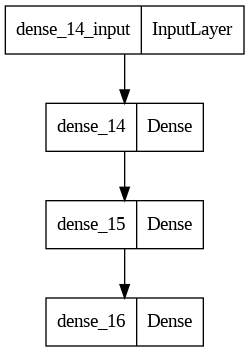

In [ ]:
plot_model(model, to_file='NN_regression_model.png')

In [ ]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/100
272/272 [==============================] - 2s 3ms/step - loss: 261.3139 - mae: 261.8139 - val_loss: 216.0910 - val_mae: 216.5907
Epoch 2/100
272/272 [==============================] - 1s 2ms/step - loss: 172.8978 - mae: 173.3970 - val_loss: 136.3264 - val_mae: 136.8246
Epoch 3/100
272/272 [==============================] - 1s 3ms/step - loss: 118.5821 - mae: 119.0808 - val_loss: 90.6656 - val_mae: 91.1646
Epoch 4/100
272/272 [==============================] - 1s 2ms/step - loss: 69.7281 - mae: 70.2261 - val_loss: 48.1242 - val_mae: 48.6216
Epoch 5/100
272/272 [==============================] - 1s 2ms/step - loss: 45.1850 - mae: 45.6812 - val_loss: 35.9460 - val_mae: 36.4400
Epoch 6/100
272/272 [==============================] - 1s 2ms/step - loss: 38.2536 - mae: 38.7477 - val_loss: 31.5963 - val_mae: 32.0886
Epoch 7/100
272/272 [==============================] - 1s 2ms/step - loss: 34.7557 - mae: 35.2470 - val_loss: 28.9816 - val_mae: 29.4708
Epoch 8/100
272/272 [==========

Построим графики зависимости потерь и средней абсолютной ошибки от количества эпох

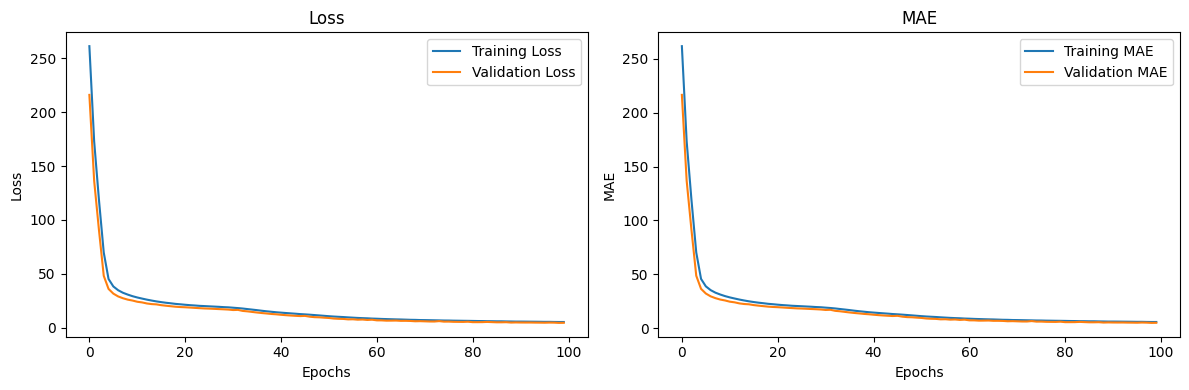

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.tight_layout()
plt.show()

Выполним предсказание на тестовой выборке и построим линию регрессии

34/34 [==============================] - 0s 2ms/step


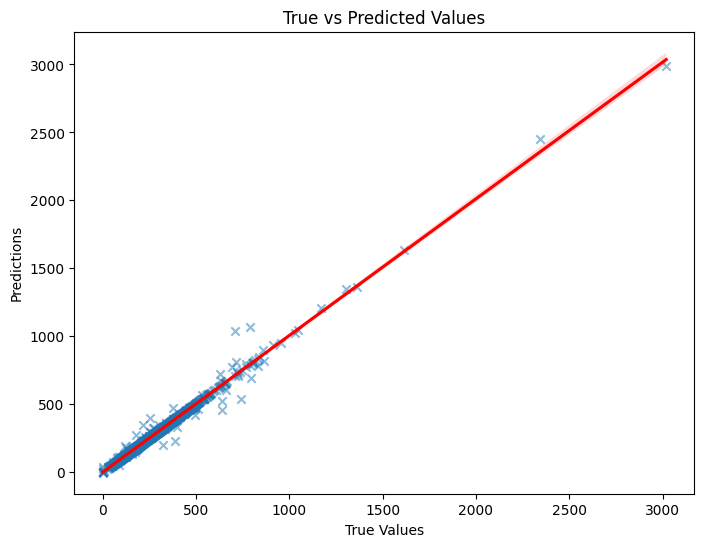

In [ ]:
# Предсказание на тестовой выборке
y_pred = model.predict(X_test)

# График с линией регрессии
plt.figure(figsize=(8, 6))
sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha':0.5}, marker="x", line_kws=dict(color="r"))
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs Predicted Values')
plt.show()

Оценка модели на тестовой выборке (метрики)

In [ ]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [ ]:
print(f"mse:\t{mse}\nmae:\t{mae}\nr2:\t{r2}")

mse:	447.8956867083341
mae:	5.266676983850844
r2:	0.9891953201651407
